# General analysis

Endogenous Rhythmic Attention project, 2019-2022

<b>Author</b>: Olof J. van der Werf
<br><b>Last updated</b>: 12-08-2022

[reference + DOI to publication]

### Purpose of this notebook

This notebook runs the general analysis of this project.

<ul>
<li>Plot behavioural data, methods</li>
<li>Analysing overall task performance</li>
</ul>

### Import necessary libraries

In [80]:
import scipy.io as sio
import numpy as np
import pandas as pd
from glob import glob
import pingouin as pg
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

### Set variables

In [103]:
# Variables

# folders containing data
clean_data_folder = 'data/data_after_cleaning/' 
figure_folder = 'figures/'

# lists with factors
conditions = ['60','80','100']
validities = ['valid','invalid']
visual_fields = ['left','right']

#### Subjects
Subjects after outlier rejection.

In [82]:
# Subject list, without outliers. 
subjects = ['03', '04', '05', '06', '09', '11', '12', '14', '15', '17', '18', '19', '20', '21', '26', '27', '30', '31', '32', '33', '34', '35', '37', '38', '39', '40']

### Import clean data

In [83]:
# Import data
file = clean_data_folder +'trials.csv'
trials = pd.read_csv(file,index_col = 0,dtype = 'str', converters = {'cue-target interval': float, 'reaction time': float})

trials

,subject,condition,validity,cue side,cue-target interval,reaction time,response
0,03,60,valid,right,1.499914,674.346,correct
1,03,60,valid,right,1.033389,535.099,correct
2,03,60,invalid,right,1.666713,677.154,correct
3,03,60,invalid,right,0.699744,642.355,correct
4,03,60,valid,left,1.199835,649.998,correct
...,...,...,...,...,...,...,...
27129,40,80,valid,left,1.616467,456.249,correct
27130,40,80,invalid,right,0.533398,809.345,correct
27131,40,80,valid,left,0.850155,375.255,correct
27132,40,80,valid,right,1.066728,700.346,correct


### Plotting functions
These below functions help with plotting our results later on.

In [84]:
# Set plotting parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

plt.rcParams["font.family"] = "helvetica"
plt.rcParams["font.size"] = 14
plt.rcParams['lines.solid_capstyle'] = 'round'

# Set color map 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''https://stackoverflow.com/a/18926541'''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Repeated measures plot
def rmplot(data,cmap,ax):
    # color map    
    conditions = data.columns
    subjects = data.index
    
    if len(conditions) == 2:
        col_list = np.linspace(0,0.5,len(conditions))
    elif len(conditions) == 3:
        col_list = np.linspace(0,1,len(conditions))
    
    # Colors
    colors = cmap(np.linspace(0, max(col_list), len(conditions)))
    
    x_coords = np.linspace(0,len(conditions),len(conditions)+1)
    
    for subject in subjects:
        # plot coloured lines
        for l in range(len(conditions)-1):
            
            pos1 = l
            pos2 = l +1
            cmap_new = truncate_colormap(cmap,col_list[l],col_list[l+1])
            x_arr = np.linspace(x_coords[pos1], x_coords[pos2], 500)
            y_arr = np.linspace(data.loc[subject,conditions[pos1]],data.loc[subject,conditions[pos2]], 500)
            cols = np.linspace(0, 1,len(x_arr))

            points = np.array([x_arr, y_arr]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, cmap = cmap_new, alpha = 0.3, zorder = 1)
            lc.set_array(cols)
            lc.set_linewidth(1)
            line = ax.add_collection(lc)
            
    # Plot individual data
    for idx, condition in enumerate(conditions):

        # Plot individual subjects
        plt.plot(np.repeat(x_coords[idx],len(data)),data[condition],'o',color = 'white',markersize = 5,markeredgewidth=0, zorder = 2, alpha =1)
        plt.plot(np.repeat(x_coords[idx],len(data)),data[condition],'o',color = colors[idx],markersize = 5,markeredgewidth=0, zorder = 2, alpha = 0.3)
        
        # Plot error bar
        pl,cap,blc = plt.errorbar(x_coords[idx], data[condition].mean(), yerr = data[condition].std(), color = colors[idx],zorder = 3, elinewidth=3)
        plt.setp(blc[0], capstyle="round")
        
        # Plot mean
        plt.plot(x_coords[idx],data[condition].mean(),'o',color = colors[idx], markeredgecolor = 'black', zorder = 4, markersize = 9)


    condition_labels = [str(c)+'%' for c in conditions]
    plt.xticks(range(len(conditions)), condition_labels)

    return x_coords

### Statistical analysis
Below, we statistically analyse our data. 

#### Getting the settings and data in order

In [85]:
# Alpha level
alpha = 0.05

In [117]:
# Get Reaction Times and Accuracy per condition

# reaction times
rt = pd.DataFrame(index = subjects, columns = conditions)
              
for subject in subjects:
    for condition in conditions:
        filtered = trials[(trials['subject'] == subject) & 
                          (trials['condition'] == condition) & 
                          (trials['validity'] == 'valid') &
                          (trials['response'] == 'correct')]
        rt.loc[subject,condition] = filtered['reaction time'].mean()

display('Reaction Times')
display(rt.head(5))

# accuracy
accuracy = pd.DataFrame(index = subjects, columns = conditions)

for subject in subjects:
    for condition in conditions:
        filtered = trials[(trials['subject'] == subject) & 
                          (trials['condition'] == condition) & 
                          (trials['validity'] == 'valid')]
        accuracy.loc[subject,condition] = filtered['response'].value_counts(normalize=True)['correct']
        
display('Accuracy:')
display(accuracy.head(5))

'Reaction Times'

,60,80,100
03,444.440396,443.441917,403.235071
04,432.043916,398.178116,402.129254
05,639.268305,610.479449,503.300212
06,442.335185,425.5047,436.331587
09,504.827472,504.153515,495.393753


'Accuracy:'

,60,80,100
03,0.947368,0.965035,0.975694
04,0.971731,0.964912,0.975524
05,0.867704,0.92549,0.620301
06,0.992933,0.985765,0.989247
09,0.970588,0.979675,0.973333


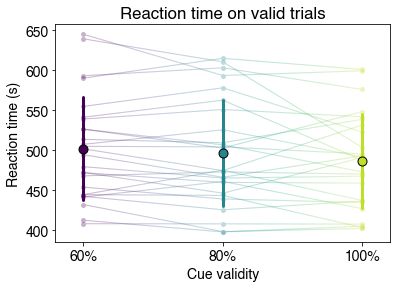

In [87]:
# Plot reaction time
fig, ax = plt.subplots()
cmap = truncate_colormap('viridis',0,0.9) # Set color map
rmplot(rt,cmap,ax)

ax.set_xlabel('Cue validity')
ax.set_ylabel('Reaction time (s)')
ax.set_xlim([-0.2,2.2])
ax.set_title('Reaction time on valid trials')
plt.show()

In [110]:
# Prepare data for RM ANOVA
converted = pd.DataFrame()
n = 1
for subject in subjects:
    for condition in conditions:
        for visual_field in visual_fields:
            converted.loc[n,'subject'] = subject
            converted.loc[n,'condition'] = condition
            converted.loc[n,'visual field'] = visual_field
            rt_filtered = trials[(trials['subject'] == subject) &
                                 (trials['condition'] == condition) & 
                                 (trials['cue side'] == visual_field) & 
                                 (trials['response'] == 'correct') &
                                 (trials['validity'] == 'valid')]
            converted.loc[n,'reaction time'] = rt_filtered['reaction time'].mean()
            
            accuracy_filtered = trials[(trials['subject'] == subject) & 
                                       (trials['condition'] == condition) & 
                                       (trials['cue side'] == visual_field) & 
                                       (trials['validity'] == 'valid')]            
            converted.loc[n,'accuracy'] = accuracy_filtered['response'].value_counts(normalize=True)['correct']
            n += 1

converted.head(60)

,subject,condition,visual field,reaction time,accuracy
1,03,60,left,443.063563,0.944056
2,03,60,right,445.817230,0.950704
3,03,80,left,450.221387,0.951389
4,03,80,right,436.759993,0.978873
5,03,100,left,411.631844,0.979167
6,03,100,right,394.778321,0.972222
7,04,60,left,441.636732,0.971831
8,04,60,right,422.381080,0.971631
9,04,80,left,412.721087,0.965035
10,04,80,right,383.528993,0.964789


In [111]:
# Repeated Measures ANOVA
aov = pg.rm_anova(dv='reaction time', within=['condition','visual field'], subject='subject', data=converted, correction = True)
print("Two-way RM ANOVA on reaction times:")
display(aov)

Two-way RM ANOVA on reaction times:


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,6412.473418,2,50,3206.236709,3.216691,0.048512,0.063160,0.009874,0.768309
1,visual field,17486.655942,1,25,17486.655942,13.179138,0.001272,0.001272,0.026474,1.000000
2,condition * visual field,693.735080,2,50,346.867540,3.314048,0.044509,0.048824,0.001078,0.923329


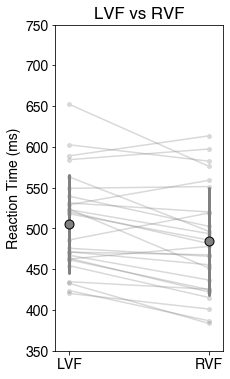

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.684888,25,two-sided,0.001108,"[9.43, 33.34]",0.339769,31.436,0.384531


In [112]:
# Follow-up test: visual field
rt_vf = pd.DataFrame(index = subjects, columns = visual_fields)
for subject in subjects:
    for visual_field in visual_fields:
        filtered = trials[(trials['subject'] == subject) &
                          (trials['cue side'] == visual_field) & 
                          (trials['validity'] == 'valid') &
                          (trials['response'] == 'correct')]
        rt_vf.loc[subject,visual_field] = filtered['reaction time'].mean()

test = pg.ttest(list(rt_vf['left']),list(rt_vf['right']), paired=True)

# Plot subject data using coloured lines
fig, ax = plt.subplots(figsize=(3,6))

# Colors
color = 'grey'

x_coords = [0,1]

for subject in subjects:
    # plot coloured line
    x1 = 0
    x2 = 1
    y1 = rt_vf.loc[subject,'left']
    y2 = rt_vf.loc[subject,'right']
    
    ax.plot((x1,x2),(y1,y2),color = 'grey',alpha = 0.3)

# Plot individual data
for idx, location in enumerate(visual_fields):

    # Plot individual subjects
    plt.plot(np.repeat(x_coords[idx],len(rt_vf)),rt_vf[location],'o',color = 'white',markersize = 5,markeredgewidth=0, zorder = 2, alpha =1)
    plt.plot(np.repeat(x_coords[idx],len(rt_vf)),rt_vf[location],'o',color = 'grey',markersize = 5,markeredgewidth=0, zorder = 2, alpha = 0.3)

    # Plot error bar
    pl,cap,blc = plt.errorbar(x_coords[idx], rt_vf[location].mean(), yerr = rt_vf[location].std(), color = 'grey',zorder = 3, elinewidth=3)
    plt.setp(blc[0], capstyle="round")

    # Plot mean
    plt.plot(x_coords[idx],rt_vf[location].mean(),'o',color = 'grey', markeredgecolor = 'black', zorder = 4, markersize = 9)

ax.set_ylabel('Reaction Time (ms)')
ax.set_xlim([-0.1,1.1])
ax.set_ylim([350,750])
ax.set_title('LVF vs RVF')
plt.xticks(range(len(visual_fields)), ['LVF','RVF'])
plt.show()

display(test)

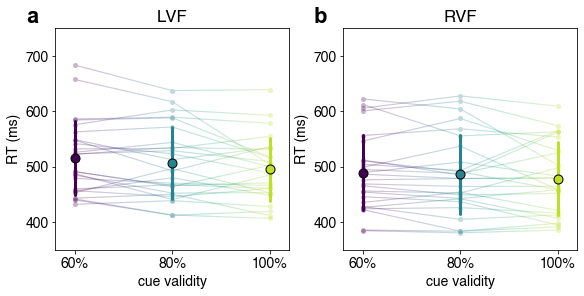

One-way RM ANOVA of condition on RT for the left visual field:


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,condition,2,50,5.318677,0.008049,0.011046,0.018725,0.878092,True,0.861167,0.16636


One-way RM ANOVA of condition on RT for the right visual field:


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,condition,2,50,1.316385,0.277233,0.27318,0.004312,0.732373,False,0.634576,0.004264


<Figure size 432x288 with 0 Axes>

In [119]:
# Follow-up test: interaction effect
fig = plt.figure(figsize=(8,4),constrained_layout=True)
gs = fig.add_gridspec(1,2)

letters = ['a','b']
titles = ['LVF','RVF']

# Data
for idx,visual_field in enumerate(['left','right']):
    rt = pd.DataFrame(index = subjects, columns = conditions)
    for subject in subjects:
        for condition in conditions:
            filtered = trials[(trials['subject'] == subject) &
                              (trials['condition'] == condition) &
                              (trials['cue side'] == visual_field) & 
                              (trials['validity'] == 'valid') &
                              (trials['response'] == 'correct')]
            rt.loc[subject,condition] = filtered['reaction time'].mean() 
        
    # Plot subject data using coloured lines
    ax = fig.add_subplot(gs[0,idx])
    rmplot(rt,cmap,ax)

    ax.set_xlabel('cue validity')
    ax.set_ylabel('RT (ms)')
    ax.set_xlim([-0.2,2.2])
    ax.set_ylim([350,750])
    ax.text(-0.1, 1.05,letters[idx], ha='center', va='center', transform=ax.transAxes, font = 'arial', size = 22, weight='bold')
    plt.title(titles[idx])
    
plt.show()
plt.savefig(figure_folder+'supplementary_1.png',dpi = 300)

# Follow-up test: interaction effect
for idx,visual_field in enumerate(['left','right']):
    filtered = converted[converted['visual field'] == visual_field]
    aov = pg.rm_anova(dv='reaction time', within=['condition'], subject='subject', data=filtered, correction = True)
    print("One-way RM ANOVA of condition on RT for the "+visual_field+" visual field:")
    display(aov)

In [116]:
# Follow-up pairwise comparisons:
filtered = converted[converted['visual field'] == 'left']

# T-Test between conditions
combinations = list(itertools.combinations(conditions, 2))
for c1,c2 in combinations:
    a = filtered[filtered['condition'] == c1]['reaction time']
    b = filtered[filtered['condition'] == c2]['reaction time']
    test = pg.ttest(a,b, paired=True)
    print('Condition '+str(c1)+'% vs Condition '+str(c2)+'%:') 
    display(test)
print('[The adjusted alpha level is: '+str(round(alpha/len(combinations),3))+']')
print('\nMeans:')
for condition in conditions:
    mean = round(filtered[filtered['condition'] == condition]['reaction time'].mean(),2)
    std = round(filtered[filtered['condition'] == condition]['reaction time'].std(),2)
    print('Condition '+str(condition)+'%: '+str(mean)+' ± '+str(std)) 

Condition 60% vs Condition 80%:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.791439,25,two-sided,0.085338,"[-1.35, 19.43]",0.138856,0.834,0.104616


Condition 60% vs Condition 100%:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.034837,25,two-sided,0.005552,"[6.65, 34.72]",0.335925,7.775,0.377367


Condition 80% vs Condition 100%:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.657029,25,two-sided,0.110012,"[-2.83, 26.11]",0.19167,0.689,0.155773


[The adjusted alpha level is: 0.017]

Means:
Condition 60%: 515.51 ± 65.86
Condition 80%: 506.47 ± 64.32
Condition 100%: 494.83 ± 56.95


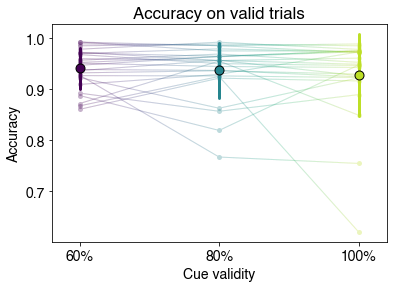

In [29]:
# Plot
fig, ax = plt.subplots()
cmap = truncate_colormap('viridis',0,0.9) # Set color map
rmplot(accuracy,cmap,ax)

ax.set_xlabel('Cue validity')
ax.set_ylabel('Accuracy')
ax.set_xlim([-0.2,2.2])
ax.set_title('Accuracy on valid trials')
plt.show()
#plt.savefig(figure_folder+'rt_valid.png',dpi = 300)

In [118]:
# Repeated Measures ANOVA
aov = pg.rm_anova(dv='accuracy', within=['condition','visual field'], subject='subject', data=converted, correction = True)
print("Two-way RM ANOVA on accuracy:")
display(aov)

Two-way RM ANOVA on accuracy:


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,0.004858,2,50,0.002429,0.647331,0.527772,0.498312,0.007067,0.815202
1,visual field,0.003330,1,25,0.003330,0.746981,0.395651,0.395651,0.004855,1.000000
2,condition * visual field,0.000728,2,50,0.000364,0.703877,0.499499,0.481678,0.001066,0.872058


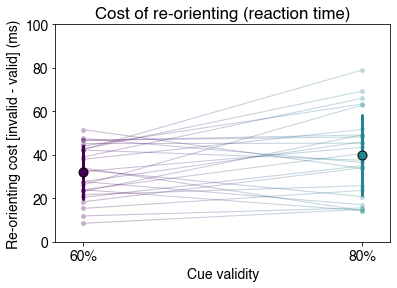

T-Test re-orienting:
60% mean ± SD = 32.08 ± 12.2
80% mean ± SD = 39.91 ± 18.55


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.510016,25,two-sided,0.018913,"[-14.24, -1.4]",0.498271,2.774,0.68518


In [125]:
# Plot reorienting effect - RT
conditions = ['60','80']

# Data
reorienting = pd.DataFrame(index = subjects, columns = conditions)
for subject in subjects:
    for condition in conditions:
        filtered = trials[(trials['subject'] == subject) &
                          (trials['condition'] == condition) & 
                          (trials['response'] == 'correct')]
        reorienting.loc[subject,condition] = filtered[filtered['validity'] == 'invalid']['reaction time'].mean() - filtered[filtered['validity'] == 'valid']['reaction time'].mean()

# Plot subject data using coloured lines
fig, ax = plt.subplots()

rmplot(reorienting,cmap,ax)

ax.set_xlabel('Cue validity')
ax.set_ylabel('Re-orienting cost [invalid - valid] (ms)')
ax.set_xlim([-0.1,1.1])
ax.set_ylim([0,100])
ax.set_title('Cost of re-orienting (reaction time)')

plt.show()

#plt.savefig(figure_folder+'reorienting_cost.png',dpi = 300)

# Run t-test

print('T-Test re-orienting:')

print('60% mean ± SD = '+str(round(reorienting['60'].mean(),2))+' ± '+str(round(reorienting['60'].std(),2)))
print('80% mean ± SD = '+str(round(reorienting['80'].mean(),2))+' ± '+str(round(reorienting['80'].std(),2)))

ttest = pg.ttest(list(reorienting['60']),list(reorienting['80']),paired = True)
display(ttest)

In [126]:
def SignificanceLine(ax,text,x1,y2,y1,ylim):
    y2 = y1-(ylim[1]-ylim[0])*0.02
    ax.plot((x1,x2),(y1,y1),color = 'black')
    ax.plot((x1,x1),(y1,y2),color = 'black')
    ax.plot((x2,x2),(y1,y2),color = 'black')
    ax.text((x2-x1)/2,y1,text,ha = 'center')

In [127]:
# Figure 1 (Methods and behavioural results)
from matplotlib import patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

conditions = ['100','80','60']
colors = plt.cm.viridis(np.linspace(0.9, 0, len(conditions)))

fig = plt.figure(figsize=(12,6),constrained_layout=True)
gs = fig.add_gridspec(3, 10)

# A. overview of trial
ax1 = fig.add_subplot(gs[0, :])
ax1.text(0, 0.9,'a', ha='center', va='center', transform=ax1.transAxes, font = 'arial', size = 22, weight='bold')
rectangles = 6
width=0.12
height=0.65
y = 0
coordinates = np.linspace(0,1-width,rectangles)
names = ['fixation','placeholders','cue','interval','target','response']
times = ['400-800 ms','300 ms','100 ms','500-1700 ms','100 ms','< 2000 ms']

# For each step in a trail, draw stuff
for idx,x in enumerate(coordinates):
    ax1.add_patch(plt.Rectangle((x,y), width, height, color = 'grey',linewidth=0))
    
    # arrow
    if idx < 5:
        head_width = 0.1
        head_length = 0.02
        ax1.arrow(x+width, y+height/2,coordinates[idx+1]-(x+width)-head_length,0,color='black',head_width = head_width, head_length = head_length)
    
    # names
    if idx != 2:
        ax1.text(x+width/2,0.75,names[idx],va='center',ha='center',size=14)
    else:
        ax1.text(x+width*0.2,0.75,names[idx],va='center',ha='center',size=14)
        
    # times
    ax1.text(x+width/2,-0.1,times[idx],va='center',ha='center',size=12)
    
    if idx == 4:
        image = plt.imread('gabor.png')
        im = OffsetImage(image, zoom=0.17)
        ab = AnnotationBbox(im, (x+width*0.75, y+height/2), xycoords='data', frameon=False)
        ax1.add_artist(ab)
        
    if idx > 0 and idx < 5:
        ax1.add_artist(patches.Ellipse((x+width*0.25,y+height/2), 0.02,0.2, facecolor = 'None',linewidth=0.5,edgecolor = 'lightgrey',zorder = 9))
        ax1.add_artist(patches.Ellipse((x+width*0.75,y+height/2), 0.02,0.2, facecolor = 'None',linewidth=0.5,edgecolor = 'lightgrey',zorder = 10))
    
    if idx == 2:
        ax1.text(x+width/2,y+height/2,'>>•>>',font = 'arial',va='center',ha='center',size=10)
    else:
        ax1.text(x+width/2,y+height/2,'•',font = 'arial',va='center',ha='center',size=10)

# invalid cue
y=0.45
ax1.add_patch(plt.Rectangle((coordinates[2]+width/2,y), width*0.8, height*0.8, color = 'grey',linewidth=0))
ax1.add_patch(plt.Rectangle((coordinates[2]+width/2,y), width*0.8, height*0.8, facecolor = 'None',edgecolor='white',linewidth=2,zorder=3,clip_on=False))
ax1.text(coordinates[2]+width/2+width*0.4,y+height*0.4,'<<•<<',font = 'arial',va='center',ha='center',size=8)
ax1.add_artist(patches.Ellipse((coordinates[2]+width/2+width*0.25*0.8,y+height*0.4), 0.02*0.8,0.2*0.8, facecolor = 'None',linewidth=0.5,edgecolor = 'lightgrey',zorder = 9))
ax1.add_artist(patches.Ellipse((coordinates[2]+width/2+width*0.75*0.8,y+height*0.4), 0.02*0.8,0.2*0.8, facecolor = 'None',linewidth=0.5,edgecolor = 'lightgrey',zorder = 10))
ax1.text(coordinates[2]+0.005,0.55,'valid',font = 'arial',va='center',ha='left',size=9)
ax1.text(coordinates[2]+0.005+width/2,0.9,'invalid',font = 'arial',va='center',ha='left',size=9)

ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_axis_off()

# B. Conditions
ax2 = fig.add_subplot(gs[1:, :3])
ax2.text(0, 1.05,'b', ha='center', va='center', transform=ax2.transAxes, font = 'arial', size = 22, weight='bold')
width = 0.55
height = 0.3
y = np.linspace(0,1-height,3)
x = 0.3
         
for i in range(3):
         
    # Grey rectangle (screen)
    ax2.add_patch(plt.Rectangle((x,y[i]), width, height, color = 'grey',linewidth=0))
    
    # Color that indicates condition
    ax2.add_patch(plt.Rectangle((x,y[i]), width, height, facecolor = 'None',edgecolor=colors[i],linewidth=3,zorder=3,clip_on=False))
    
    # Fixation and cue
    ax2.text(x+width*0.5,y[i]+height/2,'>>•>>',font = 'arial', va='center',ha='center',size=12)
    
    # Left spot + text
    ax2.text(x+width*0.20,y[i]+height/2,str(100-conditions[i])+'%',va='center',ha='center',size=13,fontweight='bold')
    ax2.add_artist(patches.Ellipse((x+width*0.20,y[i]+height/2), 0.15,0.15, facecolor = 'lightgrey',linewidth=0))
    
    # Right spot + text
    ax2.text(x+width*0.80,y[i]+height/2,str(conditions[i])+'%',va='center',ha='center',size=13,fontweight='bold')
    ax2.add_artist(patches.Ellipse((x+width*0.80,y[i]+height/2), 0.15,0.15, facecolor = 'lightgrey',linewidth=0))
    
    # Indication text
    ax2.text(x-0.1,y[i]+height/2,str(conditions[i])+'%',size=18,ha='right',va='center')

#ax2.set_title('cue validity conditions')
ax2.set_axis_off()

# C. RT on valid trials
ax3 = fig.add_subplot(gs[1:, 3:6])
ax3.text(-0.1, 1.05, 'c', ha='center', va='center', transform=ax3.transAxes, font = 'arial', size = 22, weight='bold')

rmplot(rt,cmap,ax3)

ax3.set_xlabel('cue validity')
ax3.set_ylabel('RT (ms)')
ax3.set_xlim([-0.2,2.2])
ax3.set_ylim([360,690])

# D. Orienting effect
ax4 = fig.add_subplot(gs[1:,6:8])
ax4.text(-0.1, 1.05,'d', ha='center', va='center', transform=ax4.transAxes, font = 'arial', size = 22, weight='bold')

rmplot(reorienting,cmap,ax4)

ax4.set_xlabel('cue validity')
ax4.set_ylabel('RT$_{invalid}$ - RT$_{valid}$ (ms)')
ax4.set_xlim([-0.2,1.2])
ax4.set_ylim([5,95])
#ax4.set_title('Reorienting cost')
SignificanceLine(ax4,'*',0,1,84,ax4.get_ylim())

# E. left vs right
ax5 = fig.add_subplot(gs[1:,8:])
ax5.text(-0.1, 1.05,'e', ha='center', va='center', transform=ax5.transAxes, font = 'arial', size = 22, weight='bold')

xcoords = [0,1]
for subject in subjects:
    # plot coloured line
    y1 = rt_vf.loc[subject,'left']
    y2 = rt_vf.loc[subject,'right']
    
    ax5.plot((0,1),(y1,y2),color = 'grey',alpha = 0.3)

# Plot individual data
for idx, visual_field in enumerate(visual_fields):

    # Plot individual subjects
    ax5.plot(np.repeat(xcoords[idx],len(rt_vf)),rt_vf[visual_field],'o',color = 'white',markersize = 5,markeredgewidth=0, zorder = 2, alpha =1)
    ax5.plot(np.repeat(xcoords[idx],len(rt_vf)),rt_vf[visual_field],'o',color = 'grey',markersize = 5,markeredgewidth=0, zorder = 2, alpha = 0.3)

    # Plot error bar
    pl,cap,blc = plt.errorbar(x_coords[idx], rt_vf[visual_field].mean(), yerr = rt_vf[visual_field].std(), color = 'grey',zorder = 3, elinewidth=3)
    plt.setp(blc[0], capstyle="round")

    # Plot mean
    ax5.plot(x_coords[idx],rt_vf[visual_field].mean(),'o',color = 'grey', markeredgecolor = 'black', zorder = 4, markersize = 9)

ax5.set_ylabel('RT (ms)')
ax5.set_xlabel('visual field')
ax5.set_xlim([-0.2,1.2])
ax5.set_ylim([360,690])
SignificanceLine(ax5,'*',0,1,670,ax5.get_ylim())
a = plt.xticks([0,1],['LVF','RVF'])

fig.tight_layout(w_pad=0.4, h_pad=0.7)

#plt.show()
#plt.savefig(figure_folder+'figure_1.png',dpi = 300)


SyntaxError: invalid syntax (2507777120.py, line 13)

This is the end.

In [ ]:
# Plot accuracy on valid trials
condition_list = [60,80,100]

accuracy = pd.DataFrame(index = subjects, columns = condition_list)
for validity in ['valid','invalid']:
    if validity == 'valid':
        code = 1
    elif validity == 'invalid':
        code = 0
    for subject in subjects:
        for condition in condition_list:
            filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['validity'] == code)]
            accuracy.loc[subject,condition] = filtered['response correct'].mean()
    
    if validity == 'valid':
        print('Valid, RM ANOVA:')
        RM_ANOVA(accuracy)
    
    elif validity == 'invalid':
        t,p = ttest(accuracy[60],accuracy[80])
        print('Invalid, T-Test:')
        print('60% vs. 80%: T = '+str(t)+'p = '+str(p)+'.')
        
    # Plot
    fig, ax = plt.subplots()

    rmplot(accuracy,cmap,ax)

    ax.set_xlabel('Cue validity')
    ax.set_ylabel('Reaction time (s)')
    ax.set_xlim([-0.2,2.2])
    ax.set_title('Accuracy on '+validity+' trials')
    
    plt.savefig(figure_folder+'accuracy_'+validity+'.png',dpi = 300)

In [ ]:
# Two-way RM ANOVA with factors CONDITION and LOCATION
conditions = [60,80,100]
locations = ['left','right']
rt = pd.DataFrame(columns = ['subject','location','condition','value'])
i=0
for subject in subjects:
    for condition in conditions:
        for location in locations:
            if location == 'left':
                side = 0
            elif location == 'right':
                side = 1
            filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['cue side'] == side) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['response correct'] == 1) & (data[subject]['validity'] == 1)]
            rt.loc[i,'subject'] = subject
            rt.loc[i,'condition'] = condition
            rt.loc[i,'location'] = location
            rt.loc[i,'value'] = filtered['response time'].mean()
            i += 1
rt

#['Disgustingness', 'Frighteningness']

In [12]:
# Scrapbook
    import pingouin as pg
    spher = pg.sphericity(converted, dv = 'var', within = 'condition', subject = 'subject', method = 'mauchly', alpha = 0.05)
    print(spher[-1])
    
    print(pg.rm_anova(dv='var', within='condition', subject='subject', data=anova_input, detailed=True, correction=True))
    
    aovrm = AnovaRM(anova_input, 'var', 'subject', within=['condition'])
    res = aovrm.fit()
    
    F = res.anova_table['F Value'][0]
    p = res.anova_table['Pr > F'][0]
    df_num = res.anova_table['Num DF'][0]
    df_den = res.anova_table['Den DF'][0]
    
    print('RM ANOVA result: F['+str(df_num)+','+str(df_den)+']'+' = '+str(F)+', p = '+str(p)+'.')

    # Follow-up tests
    if p < alpha:
        print('Follow-up pairwise comparisons:')

        combinations = list(itertools.combinations(condition_list, 2))
    
        # T-Test between conditions
        for c1,c2 in combinations:
            a = data[c1]
            b = data[c2]
            t, p = ttest(a,b)
            print(str(c1)+'% vs. '+str(c2)+'%: T = '+str(t)+', p = '+str(p)+'.')
        print('The adjusted alpha level is: '+str(alpha/len(combinations)))

IndentationError: unexpected indent (1548369134.py, line 2)

In [ ]:
# Two-way RM ANOVA with factors CONDITION and LOCATION
aovrm = AnovaRM(rt, 'value', 'subject', within=['condition','location'])
res = aovrm.fit()

F = res.anova_table['F Value'][0]
p = res.anova_table['Pr > F'][0]

res.anova_table

In [ ]:
# Plot accuracy on valid trials, left and right separately
condition_list = [60,80,100]

# Data
for side in ['left','right']:
    if side == 'left':
        code = 0
    elif side == 'right':
        code = 1
    accuracy = pd.DataFrame(index = subject_list, columns = condition_list)
    for subject in subject_list:
        for condition in condition_list:
            filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['target side'] == code) & (data[subject]['validity'] == 1)]
            accuracy.loc[subject,condition] = filtered['response correct'].mean()

    # Plot subject data using coloured lines
    fig, ax = plt.subplots()
    rmplot(accuracy,cmap,ax)

    ax.set_xlabel('Cue validity')
    ax.set_ylabel('Accuracy')
    ax.set_xlim([-0.1,2.1])
    ax.set_ylim([0.5,1])
    ax.set_title('Accuracy on valid trials on the '+side+' visual field.')
    
    plt.show()
    
    print('--- '+side+' ---')
    RM_ANOVA(accuracy)
    
    plt.savefig(figure_folder+'accuracy_'+side+'.png',dpi = 300)

In [ ]:
# Compare RT on left and right
condition_list = [60,80,100]

print('Comparison of RT of left and right targets, per condition:\n')
# Data
for condition in condition_list:
    rt_sides = pd.DataFrame()
    for subject in subject_list:
        filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['response correct'] == 1) & (data[subject]['validity'] == 1)]
        rt_sides.loc[subject,'left'] = filtered[filtered['target side'] == 0]['response time'].mean()
        rt_sides.loc[subject,'right'] = filtered[filtered['target side'] == 1]['response time'].mean()
    
    t,p = ttest(rt_sides['left'],rt_sides['right'])
    print(str(condition)+'%, left vs. right: T = '+str(t)+'p = '+str(p)+'.')

In [ ]:
# Compare accuracy on left and right
condition_list = [60,80,100]

print('Comparison of accuracy of left and right targets, per condition:\n')
# Data
for condition in condition_list:
    accuracy_sides = pd.DataFrame()
    for subject in subject_list:
        filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['response correct'] == 1)]
        accuracy_sides.loc[subject,'left'] = filtered[filtered['target side'] == 0]['response correct'].mean()
        accuracy_sides.loc[subject,'right'] = filtered[filtered['target side'] == 1]['response correct'].mean()
    
    t,p = ttest(rt_sides['left'],rt_sides['right'])
    print(str(condition)+'%, left vs. right: T = '+str(t)+'p = '+str(p)+'.')

In [ ]:
# Plot reorienting effect
location_list = ['left','right']
condition_list = [60,80]

# Data
reorienting_vf = {} 
reorienting_vf['left'] = pd.DataFrame(index = subject_list, columns = condition_list)
reorienting_vf['right'] = pd.DataFrame(index = subject_list, columns = condition_list)
anova_input = pd.DataFrame(columns = ['subject','condition','location','value'])
i = 0
for subject in subject_list:
    for location in location_list:
        if location == 'left':
            side = 0
        if location == 'right':
            side = 1
        for condition in condition_list:
            filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['response correct'] == 1) & (data[subject]['target side'] == side)]
            value =  filtered[filtered['validity'] == 0]['response time'].mean() - filtered[filtered['validity'] == 1]['response time'].mean()
            reorienting_vf[location].loc[subject,condition] = value
            anova_input.loc[i,'subject'] = subject
            anova_input.loc[i,'condition'] = condition
            anova_input.loc[i,'location'] = location
            anova_input.loc[i,'value'] = value
            i += 1
            
# Two-way RM ANOVA with factors CONDITION and LOCATION
aovrm = AnovaRM(anova_input, 'value', 'subject', within=['condition','location'])
res = aovrm.fit()

F = res.anova_table['F Value'][0]
p = res.anova_table['Pr > F'][0]

res.anova_table

In [ ]:
# Run t-test for LVF and RVF separately
for location in location_list:
    t,p = ttest(reorienting_vf[location][60],reorienting_vf[location][80])
    print('T-Test re-orienting:')
    print('60% vs. 80%: T = '+str(t)+', p = '+str(p)+'.')
    for condition in condition_list:
        mean = round(reorienting_vf[location][condition].mean(),2)
        std = round(reorienting_vf[location][condition].std(),2)
        print('Condition '+str(condition)+'%: '+str(mean)+' ± '+str(std)) 

In [ ]:
# Plot subject data using coloured lines
fig, ax = plt.subplots()

rmplot(reorienting,cmap)

ax.set_xlabel('Cue validity')
ax.set_ylabel('Re-orienting cost [invalid - valid] (ms)')
ax.set_xlim([-0.1,1.1])
#ax.set_ylim([0,100])
ax.set_title('Cost of re-orienting (reaction time) towards the left visual field')

plt.savefig(figure_folder+'reorienting_cost_left_side.png',dpi = 300)

T-Test re-orienting:


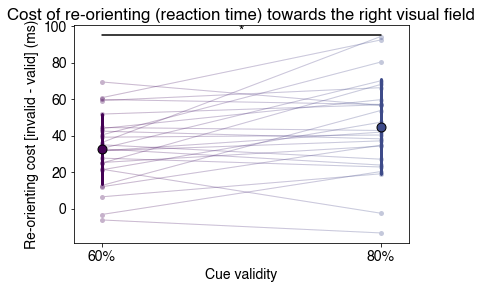

In [129]:
# Plot reorienting effect - towards the right side
condition_list = [60,80]

# Data
reorienting = pd.DataFrame(index = subjects, columns = conditions)
for subject in subjects:
    for condition in conditions:
        filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) & (data[subject]['response correct'] == 1) & (data[subject]['target side'] == 1)]
        reorienting.loc[subject,condition] = filtered[filtered['validity'] == 0]['response time'].mean() - filtered[filtered['validity'] == 1]['response time'].mean()

# Run t-test
#t,p = ttest(reorienting[60],reorienting[80])
print('T-Test re-orienting:')
#print('60% vs. 80%: T = '+str(t)+', p = '+str(p)+'.')

# Plot subject data using coloured lines
fig, ax = plt.subplots()
cmap = 
rmplot(reorienting,cmap,ax)

ax.set_xlabel('Cue validity')
ax.set_ylabel('Re-orienting cost [invalid - valid] (ms)')
ax.set_xlim([-0.1,1.1])
#ax.set_ylim([0,100])
ax.set_title('Cost of re-orienting (reaction time) towards the right visual field')
ax.plot((0,1),(95,95),color = 'black')
ax.text(0.5,95,'*',ha='center')

plt.savefig(figure_folder+'reorienting_cost_right_side.png',dpi = 300)

In [ ]:
# Plot reorienting effect - accuracy
condition_list = [60,80]

# Data
reorienting = pd.DataFrame(index = subject_list, columns = condition_list)
for subject in subject_list:
    for condition in condition_list:
        filtered = data[subject][(data[subject]['condition'] == condition) & (data[subject]['eye tracker reject'] == 0) ]
        reorienting.loc[subject,condition] = filtered[filtered['validity'] == 0]['response correct'].mean() - filtered[filtered['validity'] == 1]['response correct'].mean()

# Run t-test
t,p = ttest(reorienting[60],reorienting[80])
print('T-Test re-orienting:')
print('60% vs. 80%: T = '+str(t)+', p = '+str(p)+'.')

# Plot subject data using coloured lines
fig, ax = plt.subplots()

rmplot(reorienting,cmap)

ax.set_xlabel('Cue validity')
ax.set_ylabel('Re-orienting cost [invalid - valid] (accuracy)')
ax.set_xlim([-0.1,1.1])
ax.set_yticks(np.arange(-0.1, 0.1, 0.02))
ax.set_ylim([-0.08,0.08])
ax.set_title('Accuracy cost of re-orienting')

#plt.savefig(figure_folder+'reorienting_cost.png',dpi = 300)


In [ ]:
np.linspace(0,1,7)

In [ ]:
def SignificanceLine(ax,text,x1,y2,y1,ylim):
    y2 = y1-(ylim[1]-ylim[0])*0.02
    ax.plot((x1,x2),(y1,y1),color = 'black')
    ax.plot((x1,x1),(y1,y2),color = 'black')
    ax.plot((x2,x2),(y1,y2),color = 'black')
    ax.text((x2-x1)/2,y1,text,ha = 'center')

In [ ]:
fig, ax = plt.subplots(,figsize = (12,8))

start_rect = cycles*np.pi
rect_height = 20

for axis in range(len(condition_list)):
    ax[axis].plot(sampling_rhythm, time, color = 'grey',linewidth = 2,linestyle = 'dotted')
    ax[axis].set_xlim(-1,1)
    ax[axis].set_ylim(0,cycles*np.pi+rect_height)
    ax[axis].add_patch(plt.Rectangle((-1,start_rect), 2, rect_height, color = 'grey',linewidth=2))
    ax[axis].add_patch(plt.Rectangle((-1,start_rect), 2, rect_height, facecolor = 'None',edgecolor='black',linewidth=3,zorder=3,clip_on=False))
    ax[axis].text(0,start_rect+rect_height/2,'>>+>>',va='center',ha='center',font='arial')
    ax[axis].text(-0.6,start_rect+rect_height/2,str(100-condition_list[axis])+'%',va='center',ha='center',size=18,fontweight='bold')
    ax[axis].add_artist(patches.Ellipse((-0.6,start_rect+rect_height/2), 0.5,8, facecolor = 'lightgrey',linewidth=0))
    ax[axis].text(0.6,start_rect+rect_height/2,str(condition_list[axis])+'%',va='center',ha='center',size=18,fontweight='bold')
    ax[axis].add_artist(patches.Ellipse((0.6,start_rect+rect_height/2), 0.5,8, facecolor = 'lightgrey',linewidth=0))
    #ax[axis].axis('off')
    ax[axis].set_yticks([])
    ax[axis].set_xticks([-1,1])
    ax[axis].set_xticklabels(['low','high'])
    ax[axis].set_xlabel('attentional performance')
    for x in ['top','left','right']:
        ax[axis].spines[x].set_linewidth(0)

In [ ]:
coordinates = np.linspace(0,1,6+1)
coordinates[:-1]